A method for generating a light curve given a sigma, tau, and delta t.

In [1]:
import numpy as np
import math

def generate_DRW_LC(t_rest, sigma, tau, z):
  # Account for redshift:
  t_obs = []
  
  # Account for redshift
  tau_rf = tau / (1 + z)

  # Make first value of the light curve and declare a light curve list
  lc1 = np.random.normal(0, sigma, None)
  lc = [lc1]

  # Fill the lightcurve list
  for i in range(1, len(t_rest)):
    dt = t_rest[i] - t_rest[i - 1]
    lc_next = lc[i - 1] * np.exp(-dt / tau_rf) + np.random.normal(0, (sigma) * (1 - np.exp((-2 * dt) / tau_rf)), None)
    lc.append(lc_next)
  
  return lc


Use the genereate_DRW_LC method.

<function matplotlib.pyplot.show(*args, **kw)>

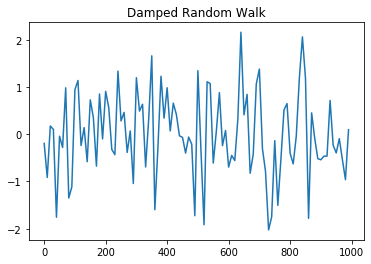

In [2]:
import matplotlib.pyplot as plt

t_rest = []
for i in range(100):
  t_rest.append(i*10)
lc = generate_DRW_LC(t_rest, 1, 1, 0)
plt.plot(t_rest, lc)
plt.title("Damped Random Walk")
plt.show

A method the calculates the chi squared between two light curves

In [3]:
def get_chi_squared(lc1, lc2):
  total = 0

  # Iterate through each value and find the chi squared. Then add to the total
  for i in range(len(lc1)):
    total = total + ( (lc1[i] - lc2[i]) * (lc1[i] - lc2[i]) )
  
  return total


A method to generate a periodic lightcurve

In [4]:
def generate_periodic_LC(t_rest, amplitude, nu, phi):
  # Create a list of points 0-2pi that will correspond to each values in t_rest
  t = []
  t_final = t_rest[len(t_rest) - 1]
  for t_current in t_rest:
    t.append((t_current / t_final) * 2 * math.pi)
  
  # Create a light curve
  F = []
  for t_current in t:
    F.append(amplitude * math.sin(nu * t_current + phi))
  
  return F
  

Use the generate_periodic_LC method

Text(0.5, 1.0, 'Periodic Lightcurve')

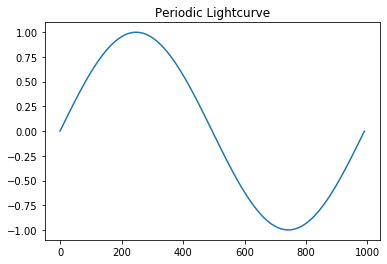

In [5]:
periodicity = generate_periodic_LC(t_rest, 1, 1, 0)
plt.plot(t_rest, periodicity)
plt.show
plt.title("Periodic Lightcurve")

A method that generates a periodic lightcurve with noise in the form of a damped random walk

In [6]:
def generate_periodic_DRW_LC(t_rest, sigma, tau, z, amplitude, nu, phi):
  # Generate the two components
  noise = generate_DRW_LC(t_rest, sigma, tau, z)
  periodicity = generate_periodic_LC(t_rest, amplitude, nu, phi)

  # Combine them
  lc = []
  for i in range(len(t_rest)):
    lc.append(noise[i] + periodicity[i])
  
  return lc


Use the generate_periodic_DRW_LC method

<function matplotlib.pyplot.show(*args, **kw)>

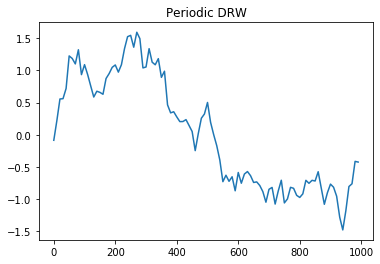

In [7]:
amplitude, nu, phi = 1, 1, 0
lc = generate_periodic_DRW_LC(t_rest, 1, 300, 2, 1, 1, 0)
plt.plot(t_rest, lc)
plt.title("Periodic DRW")
plt.show

A method that esitmates the amplitude, nu, and phi of lightcurves

In [8]:
from astropy.timeseries import LombScargle

def fit_periodicity(t_rest, lc, steps, method):
    # Create a grid of light curves with a range of amplitude, nu, and phi and find each chi^2. After finding the chi^2, compare to the best (smallest) and if smaller, replace.
    best = None, None, None
    best_chi_squared = None
    if method == 'chi2':
        for a in range(steps):
            for n in range(steps):
                for p in range(steps): 
                    # Generate lc and calculate chi^2 with given lc
                    amplitude, nu, phi = .3 + (a / steps) * 2.7, .1 + (n / (steps)) * 1.9, (p / steps) * 2 * math.pi
                    fit = generate_periodic_LC(t_rest, amplitude, nu, phi)
                    chi_squared = get_chi_squared(lc, fit)

                    # Compare to previous chi^2 minimum and replace if smaller
                    if best_chi_squared == None or chi_squared < best_chi_squared:
                        best = amplitude, nu, phi
                        best_chi_squared = chi_squared
    elif method == 'LombScargle':
        # Use LombScargle method to find the frequency and then use own chi2 method to find the a and phi
        t_rest = np.array(t_rest)
        ls = LombScargle(t_rest / max(t_rest), lc)
        frequency, power = ls.autopower(minimum_frequency=.1, maximum_frequency=5)
        best_frequency = frequency[np.argmax(power)]
        for a in range(steps):
            for p in range(steps):
                # Generate lc and calculate chi^2 with given lc
                amplitude, phi = .3 + (a / steps) * 2.7, (p / steps) * 2 * math.pi
                fit = generate_periodic_LC(t_rest, amplitude, best_frequency, phi)
                chi_squared = get_chi_squared(lc, fit)

                # Compare to previous chi^2 minimum and replace if smaller
                if best_chi_squared == None or chi_squared < best_chi_squared:
                    best = amplitude, best_frequency, phi
                    best_chi_squared = chi_squared
    
    return best


A method that estimates the amplitude, nu, and phi of lightcurves and plots a visualization of them

In [9]:
def fit_periodicity_visualization(lc, steps):
  # Create a grid of light curves with a range of amplitude, nu, and phi and find each chi^2. After finding the chi^2, compare to the best (smallest) and if smaller, replace.
  t_rest = list(range(0,len(lc)))
  best = None, None, None
  best_chi_squared = None
  for a in range(steps):
    for n in range(steps):
      for p in range(steps): 
        # Generate lc and calculate chi^2 with given lc
        amplitude, nu, phi = .3 + (a / steps) * 2.7, .1 + (n / (steps)) * 1.9, (p / steps) * 2 * math.pi
        fit = generate_periodic_LC(t_rest, amplitude, nu, phi)
        chi_squared = get_chi_squared(lc, fit)

        # Compare to previous chi^2 minimum and replace if smaller
        if best_chi_squared == None or chi_squared < best_chi_squared:
          best = amplitude, nu, phi
          best_chi_squared = chi_squared

  # Iterate over two variables at a time while the third is fixed to the best in order to make a countour plot
  chi1 = [[None for i in range(steps)] for j in range(steps)]
  a1 = []
  n1 = []
  for a in range(steps):
    for n in range(steps):
      amplitude, nu = .3 + (a / steps) * 2.7, .1 + (n / (steps)) * 1.9
      if n == 0:
        a1.append(amplitude)
      if a == 0:
        n1.append(nu)
      fit = generate_periodic_LC(t_rest, amplitude, nu, best[2])
      chi = get_chi_squared(lc, fit)
      chi1[a][n] = chi
  chi2 = [[None for i in range(steps)] for j in range(steps)]
  a2 = []
  p2 = []
  for a in range(steps):
    for p in range(steps):
      amplitude, phi = .3 + (a / steps) * 2.7, (p / steps) * 2 * math.pi
      if p == 0:
        a2.append(amplitude)
      if a == 0:
        p2.append(phi)
      fit = generate_periodic_LC(t_rest, amplitude, best[1], phi)
      chi = get_chi_squared(lc, fit)
      chi2[a][p] = chi
  chi3 = [[None for i in range(steps)] for j in range(steps)]
  n3 = []
  p3 = []
  for n in range(steps):
    for p in range(steps):
      nu, phi = .1 + (n / (steps)) * 1.9, (p / steps) * 2 * math.pi
      if p == 0:
        n3.append(nu)
      if n == 0:
        p3.append(phi)
      fit = generate_periodic_LC(t_rest, best[0], nu, phi)
      chi = get_chi_squared(lc, fit)
      chi3[n][p] = chi
  

  # Plot the data
  color_map = plt.cm.get_cmap('Reds')
  color_map_reversed = color_map.reversed()
  plt.figure()
  plt.title("Chi Squared Contour Plots")
  p1 = plt.contourf(a1, n1, chi1, cmap = color_map_reversed)
  plt.colorbar(p1)
  plt.xlabel('A')
  plt.ylabel('Nu')

  plt.figure()
  p2 = plt.contourf(a2, p2, chi2, cmap = color_map_reversed)
  plt.colorbar(p2)
  plt.xlabel('A')
  plt.ylabel('Phi')

  plt.figure()
  p3 = plt.contourf(n3, p3, chi3, cmap = color_map_reversed)
  plt.colorbar(p3)
  plt.xlabel('Nu')
  plt.ylabel('Phi')


Use the fit_periodicity method to fit nu, phi, and amplitude to a generated light curve. Here we will only use periodic light curves.

Amplitudes:  1.987507387324077 2.055
Nus:  1.693905867861156 1.7000000000000002
Phis:  4.3355939602195335 4.39822971502571


<function matplotlib.pyplot.show(*args, **kw)>

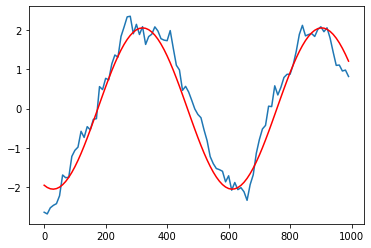

In [10]:
import random

# Generate random variables for amplitude, nu, phi within given ranges
amplitude, nu, phi = random.uniform(.3, 3), random.uniform(.1, 2), random.uniform(0, 2*math.pi)
lc = generate_periodic_DRW_LC(t_rest, 1, 300, 2, amplitude, nu, phi)

# Find best nu, phi, and amplitude
amplitude_est, nu_est, phi_est = fit_periodicity(t_rest, lc, 20, "LombScargle")

print('Amplitudes: ', amplitude, amplitude_est)
print('Nus: ', nu, nu_est)
print('Phis: ', phi, phi_est)

plt.plot(t_rest, lc)
plt.show
plt.plot(t_rest, generate_periodic_LC(t_rest, amplitude_est, nu_est, phi_est), 'r')
plt.show

Visualize the variable chi^2

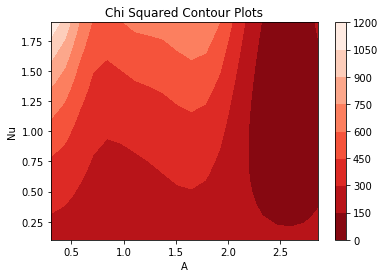

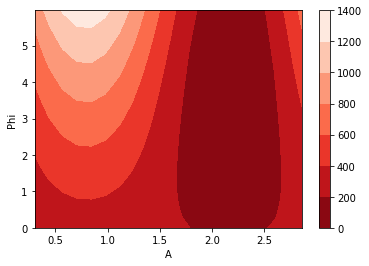

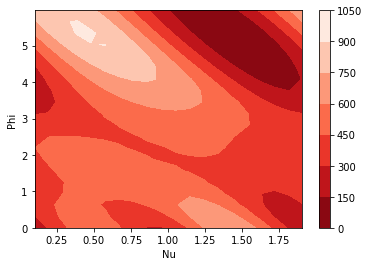

In [11]:
fit_periodicity_visualization(lc, 20)

A method to generate the covariance matrix of a lightcurve given a sigma and tau

In [203]:
def generate_cov_matrix(delta_t_matrix, sigma, tau):
    # Generate the covariance matrix
    cov_matrix = sigma * sigma * np.exp((-1.0 * delta_t_matrix) / tau)

    return cov_matrix

A method to generate the result of the delta function described in Eq. 5 of Liu Gezari 2018

In [13]:
def get_delta_function_result(amplitude, frequency, delta_t_matrix):
    # Use the delta equation to calculate a result
    result = amplitude * np.cos(2 * np.pi * frequency * delta_t)
    
    return result

A method to generate the covariance matrix of a lightcurve given a sigma, tau, amplitude, and frequency using the formula in Eq. 5 of Liu Gezari 2018

In [258]:
def generate_cov_matrix_delta_function(delta_t_matrix, sigma, tau, amplitude, frequency):
    # Generate the covariance matrix that includes the periodic signal by adding Liu and Gezari's delta function
    cov_matrix = sigma * sigma * np.exp((-1.0 * delta_t_matrix) / tau) + amplitude * np.cos(2 * np.pi * frequency * delta_t_matrix)
   
    return cov_matrix

Used to get the likelihood of a tau and sigma given a tau, sigma, and lightcurve

In [15]:
import numpy as np
from numpy import linalg

def get_likelihood0(t_rest, lc, sigma, tau, z):
  # Generate necessary components of the likelihood formula
  fit = generate_DRW_LC(t_rest, sigma, tau, z) # The fit with the given sigma and tau
  S = generate_cov_matrix(t_rest, sigma, tau) # Cov matrix of the lc
  C_inv = linalg.inv(S) # Inverse of C (C = S + N) N is cov matrix of noise
  L = [1 for i in range(len(t_rest))] # Matrix of 1s
  L_trans = np.transpose(L) # L transposed
  q = sum(lc)/ len(lc) # Mean of the lightcurve
  Lq = [None for i in range(len(L))] # A component of the realization of the lightcurve
  for i in range(len(L)):
    Lq[i] = L[i] * q
  y = [sum(x) for x in zip(lc, Lq)] # realization of the light curve y = s + n(noise = 0) + Lq
  y_trans = np.transpose(y) # y transposed
  C_inv_uptack = C_inv - np.multiply(np.matmul(np.multiply(np.matmul(C_inv, L), 1 / np.matmul(np.matmul(L_trans, C_inv),L)), L_trans), C_inv)
  exp = -(np.matmul(np.matmul(y_trans, C_inv_uptack), y)) / 2
  likelihood = math.pow(linalg.norm(S) * math.pow(np.matmul(np.matmul(L_trans, C_inv), L), -1/2), exp)
  return likelihood


In [62]:
def get_likelihood1(t_rest, lc, sigma, tau, z):
  # Generate necessary components of the likelihood formula
  fit = generate_DRW_LC(t_rest, sigma, tau, 0) # The fit with the given sigma and tau
    
  S = generate_cov_matrix(t_rest, 1.2, 300) # Cov matrix of the lc
  C_inv = linalg.inv(S) # Inverse of C (C = S + N) N is cov matrix of noise
  L = [1 for i in range(len(t_rest))] # Matrix of 1s
  L_trans = np.transpose(L) # L transposed
  q = sum(lc)/ len(lc) # Mean of the lightcurve
  Lq = [None for i in range(len(L))] # A component of the realization of the lightcurve
  for i in range(len(L)):
    Lq[i] = L[i] * q
  y = [sum(x) for x in zip(fit, Lq)] # realization of the light curve y = s + n(noise = 0) + Lq
  y_trans = np.transpose(y) # y transposed
  C_inv_uptack = C_inv - np.multiply(np.matmul(np.multiply(np.matmul(C_inv, L), 1 / np.matmul(np.matmul(L_trans, C_inv),L)), L_trans), C_inv)
  exp = -(np.matmul(np.matmul(y_trans, C_inv_uptack), y)) / 2
  likelihood = math.pow(linalg.norm(S) * math.pow(np.matmul(np.matmul(L_trans, C_inv), L), -1/2), exp)
  return likelihood


In [191]:
def get_loglikelihood(delta_t_matrix, lc, sigma, tau, z):
    S = generate_cov_matrix(delta_t_matrix, sigma, tau) # Cov matrix of the lc
    C_inv = linalg.inv(S) # Inverse of C (C = S + N) N is cov matrix of noise
    L = np.zeros((len(delta_t_matrix), 1)) + 0.5 # Matrix of 0.5s
    L_trans = np.transpose(L) # L transposed
    y = np.zeros((len(delta_t_matrix), 1)) # Matrix of given light curve
    y[:,0] = lc
    y_trans = np.transpose(y) # y transposed
    C_inv_up1 = C_inv 
    denom = np.matmul(np.matmul(L_trans, C_inv), L) # Denominator of likelihood equation
    A = np.matmul(L_trans, C_inv)
    B = np.matmul(C_inv,L)
    C_inv_uptack = C_inv_up1 - np.matmul(B,A) / denom
    expval = -0.5 * (np.matmul(np.matmul(y_trans, C_inv_uptack), y))
    loglikelihood = (-0.5) * linalg.slogdet(S)[1] + np.log(pow(np.abs(denom), -0.5)) + expval 
 
    return loglikelihood[0][0]

In [252]:
def get_loglikelihood_periodic(delta_t_matrix, lc, sigma, tau, amplitude, frequency, z):
    S = generate_cov_matrix_delta_function(delta_t_matrix, sigma, tau, amplitude, frequency) # Cov matrix of the lc
    C_inv = linalg.inv(S) # Inverse of C (C = S + N) N is cov matrix of noise
    L = np.zeros((len(delta_t_matrix), 1)) + 0.5 # Matrix of 0.5s
    L_trans = np.transpose(L) # L transposed
    y = np.zeros((len(delta_t_matrix), 1)) # Matrix of given light curve
    y[:,0] = lc
    y_trans = np.transpose(y) # y transposed
    C_inv_up1 = C_inv 
    denom = np.matmul(np.matmul(L_trans, C_inv), L) # Denominator of likelihood equation
    A = np.matmul(L_trans, C_inv)
    B = np.matmul(C_inv,L)
    C_inv_uptack = C_inv_up1 - np.matmul(B,A) / denom
    expval = -0.5 * (np.matmul(np.matmul(y_trans, C_inv_uptack), y))
    loglikelihood = (-0.5) * linalg.slogdet(S)[1] + np.log(pow(np.abs(denom), -0.5)) + expval 
 
    return loglikelihood[0][0]

A method to fit DRWs to sigma and taus

In [217]:
def fit_DRW(t_rest, lc, z, steps, sigma_range = [.1, 10], tau_range = [1, 100]):
    # Create variables that will be used to maximize likelihood
    sigmas = np.array([sigma_range[0] + (s / steps) * (sigma_range[1] - sigma_range[0]) for s in range(steps + 1)])
    taus = np.array([tau_range[0] + (t / steps) * (tau_range[1] - tau_range[0]) for t in range(steps + 1)])
    loglikelihoods = np.zeros((len(sigmas), len(taus)))
    delta_t_matrix = np.zeros((len(t_rest), len(t_rest)))
    for i in range(len(t_rest)):
        for j in range(len(t_rest)):
            delta_t_matrix[i][j] = abs(t_rest[i] - t_rest[j])
    
    # Find the likelihood of all sigmas and taus and then return the one that affords the greatest likelihood
    for s in range(len(sigmas)):
        for t in range(len(taus)):
            loglikelihoods[s][t] = get_loglikelihood(delta_t_matrix, lc, sigmas[s], taus[t], 0)
    cords = np.where(loglikelihoods == np.amax(loglikelihoods))
    fits = sigmas[cords[0][0]], taus[cords[1][0]]

    return fits

A method to fit periodic DRWs to sigmas, taus, amplitudes, and frequencies

In [262]:
def fit_periodic_DRW_likelihood(t_rest, lc, z, steps, sigma_range = [.1, 10], tau_range = [1, 100]):
    # Create variables that will be used to maximize likelihood
    sigmas = np.array([sigma_range[0] + (s / steps) * (sigma_range[1] - sigma_range[0]) for s in range(steps + 1)])
    taus = np.array([tau_range[0] + (t / steps) * (tau_range[1] - tau_range[0]) for t in range(steps + 1)])
    amplitudes = np.array([.01 + (a / steps) * .99 for a in range(steps + 1)])
    frequencies = np.array([1 + (f / steps) * 2 for f in range(steps + 1)])
    loglikelihoods = np.zeros((len(sigmas), len(taus), len(amplitudes), len(frequencies)))
    delta_t_matrix = np.zeros((len(t_rest), len(t_rest)))
    for i in range(len(t_rest)):
        for j in range(len(t_rest)):
            delta_t_matrix[i][j] = abs(t_rest[i] - t_rest[j])
    
    # Find the likelihood of all different combinations of parameters and then return the one that affords the greatest likelihood
    for s in range(len(sigmas)):
        for t in range(len(taus)):
            for a in range(len(amplitudes)):
                for f in range(len(frequencies)):
                    loglikelihoods[s][t][a][f] = get_loglikelihood_periodic(delta_t_matrix, lc, sigmas[s], taus[t], amplitudes[a], frequencies[f], 0)
    cords = np.where(loglikelihoods == loglikelihoods.max())
    print(cords)
    fits = sigmas[cords[0][0]], taus[cords[1][0]], amplitudes[cords[2][0]], frequencies[cords[3][0]]
  
    return fits

Use the fit_DRW method

Sigmas:  2.0 1.5142857142857145
Taus:  10 12.314285714285713


<function matplotlib.pyplot.show(*args, **kw)>

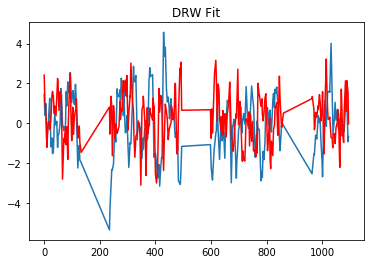

In [218]:
sigma, tau = 2.0, 10
times_VR = generate_Vera_Rubin_times(100, 3)
lc = generate_DRW_LC(times_VR, sigma, tau, 0)
sigma_est, tau_est = fit_DRW(times_VR, lc, 0, 35)
print('Sigmas: ', sigma, sigma_est)
print('Taus: ', tau, tau_est)

plt.plot(times_VR, lc)
plt.plot(times_VR, generate_DRW_LC(times_VR, sigma_est, tau_est, 2), 'r')
plt.title("DRW Fit")
plt.show

A method that estimates the sigma and of lightcurves and plots a visualization of them

In [22]:
import sys


def fit_DRW_visualization(lc, t_rest, z, steps):
  # Iterate over sigma and taus and create a grid for visualization
  # loglikelihoods = [[None for i in range(steps + 1)] for j in range(steps + 1)]
  loglikelihoods = np.zeros((steps + 1, steps + 1))
  taus = []
  sigmas = []
  best_loglikelihood = None
  best = None, None
  for s in range(steps + 1):
    for t in range(steps + 1):
      sigma, tau = .1 + (s / steps) * 10, 1 + (t / steps) * 100
      if t == 0:
        sigmas.append(sigma)
      if s == 0:
        taus.append(tau)
      loglikelihood = get_loglikelihood(t_rest, lc, sigma, tau, z)
      loglikelihoods[s][t] = loglikelihood  
      if best_loglikelihood == None or loglikelihood > best_loglikelihood:
        best_loglikelihood = loglikelihood
        best = sigma, tau

  # Plot the data
  color_map = plt.cm.get_cmap('Reds')
  p1 = plt.contourf(sigmas, taus, loglikelihoods, cmap = color_map, levels=np.linspace(-200,0,15))
  plt.colorbar(p1)
  plt.xlabel('\u03C3') # Sigma
  plt.ylabel('\u03C4') # Tau
  plt.title("log(likelihood)")


Visualize the loglikelihood

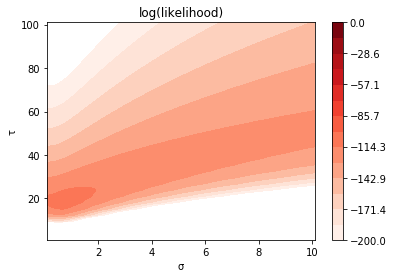

In [23]:
fit_DRW_visualization(lc, t_rest, 0, 35)

A method to fit a periodic DRW. We will find the periodicity and subtract it. Then we will fit the resulting light curve

In [25]:
def fit_periodic_DRW(lc, t_rest, z, steps, method):
    # Fit the periodicity of the lightcurve and then subtract it
    amplitude, nu, phi = fit_periodicity(t_rest, lc, steps, method)
    periodicity = generate_periodic_LC(t_rest, amplitude, nu, phi)
    periodicity_neg = [-x for x in periodicity]
    non_periodic = [sum(x) for x in zip(lc, periodicity_neg)]

    # Fit the light curve to a sigma and tau
    sigma, tau = fit_DRW(t_rest, non_periodic, z, steps)

    return sigma, tau, amplitude, nu, phi


Use the fit_periodic_DRW method

Sigmas:  1.5 1.2314285714285715
Taus:  10 17.97142857142857
Amplitudes:  2.5 2.5371428571428574
Nus:  1.6 1.5000000000000002
Phis:  0 0.35903916041026207


<function matplotlib.pyplot.show(*args, **kw)>

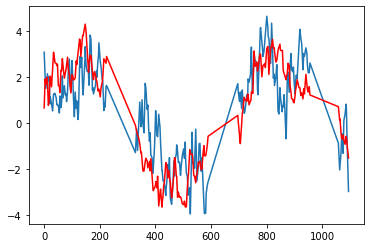

In [196]:
# Generate a periodic DRW and then fit it
times_VR = generate_Vera_Rubin_times(100, 3)
sigma, tau, amplitude, nu, phi = 1.5, 10, 2.5, 1.6, 0
periodic_lc = generate_periodic_DRW_LC(times_VR, sigma, tau, 0, amplitude, nu, phi)
sigma_est, tau_est, amplitude_est, nu_est, phi_est = fit_periodic_DRW(periodic_lc, times_VR, 0, 35, 'LombScargle')

# Visualize periodic DRW and fit
print('Sigmas: ', sigma, sigma_est)
print('Taus: ', tau, tau_est)
print('Amplitudes: ', amplitude, amplitude_est)
print('Nus: ', nu, nu_est)
print('Phis: ', phi, phi_est)
lc = generate_periodic_DRW_LC(times_VR, sigma, tau, 0, amplitude, nu, phi)
lc_est = generate_periodic_DRW_LC(times_VR, sigma_est, tau_est, 0, amplitude_est, nu_est, phi_est)

plt.plot(times_VR, lc)
plt.plot(times_VR, lc_est, 'r')
plt.show

Use the fit_DRW_periodic method

(array([2]), array([6]), array([0]), array([7]))
Sigmas:  1.5 2.08
Taus:  10 60.4
Amplitudes:  2.5 0.01
Nus:  1.6 2.4


<function matplotlib.pyplot.show(*args, **kw)>

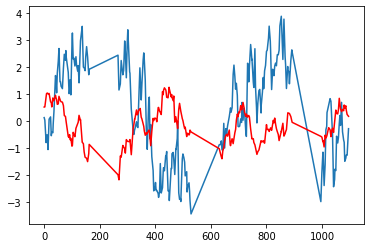

In [263]:
# Generate a periodic DRW and then fit it
sigma, tau, amplitude, nu, phi = 1.5, 10, 2.5, 1.6, 0
times_VR = generate_Vera_Rubin_times(100, 3)
periodic_lc = generate_periodic_DRW_LC(times_VR, sigma, tau, 0, amplitude, nu, phi)
sigma_est, tau_est, amplitude_est, nu_est = fit_periodic_DRW_likelihood(times_VR, periodic_lc, 0, 10)

# Visualize periodic DRW and fit
print('Sigmas: ', sigma, sigma_est)
print('Taus: ', tau, tau_est)
print('Amplitudes: ', amplitude, amplitude_est)
print('Nus: ', nu, nu_est)
lc = generate_periodic_DRW_LC(times_VR, sigma, tau, 0, amplitude, nu, phi)
lc_est = generate_periodic_DRW_LC(times_VR, sigma_est, tau_est, 0, amplitude_est, nu_est, phi)

plt.plot(times_VR, lc)
plt.plot(times_VR, lc_est, 'r')
plt.show

A method to visualize fitting the periodic DRW by subtracting periodicity

In [ ]:
def fit_periodic_DRW_visualization(lc, t_rest, z, steps):
  # Fit the periodicity of the lightcurve and then subtract it
  amplitude, nu, phi = fit_periodicity(lc, steps)
  periodicity = generate_periodic_LC(t_rest, amplitude, nu, phi)
  periodicity_neg = [-x for x in periodicity]
  non_periodic = [sum(x) for x in zip(lc, periodicity_neg)]

  # Plot the periodic DRW and its fit
  fig, axs = plt.subplots(3)
  axs[0].plot(t_rest, lc)
  axs[0].plot(t_rest, periodicity, 'r')
  axs[0].set_title('Fit Periodicity')

  # Fit the light curve to a sigma and tau
  sigma, tau = fit_DRW(t_rest, non_periodic, z, steps)
  DRW_fit = generate_DRW_LC(t_rest, sigma, tau, z)
  axs[1].plot(t_rest, non_periodic)
  axs[1].plot(t_rest, DRW_fit, 'r')
  axs[1].set_title('Fit DRW')

  axs[2].plot(t_rest, lc)
  axs[2].plot(t_rest, generate_periodic_DRW_LC(t_rest, sigma, tau, z, amplitude, nu, phi), 'r')
  axs[2].set_title('Fit Periodicity With DRW')


Use the fit_periodic_DRW_visualization method

In [ ]:
fit_periodic_DRW_visualization(lc, t_rest, 0, 35)

Use atropy.timeseries.LombScargle to find the periodicity of the periodic DRW

In [ ]:
from astropy.timeseries import LombScargle

rand = np.random.RandomState(42)
t_uneven = 1000 * rand.rand(1000)
t_uneven.sort()

lc = np.array(generate_periodic_LC(t_uneven, 1, 2, 0))
ls = LombScargle(t_uneven / max(t_uneven), lc)
frequency, power = ls.autopower(minimum_frequency=.1, maximum_frequency=5)
best_frequency = frequency[np.argmax(power)]


plt.figure()
plt.title("Lomb Scargle Periodogram")
plt.plot(frequency, power)
plt.figure()
plt.title("Lomb Scargle Fit")
plt.scatter(t_uneven, lc, s = 10)
plt.plot(t_uneven, generate_periodic_LC(t_uneven, 1, best_frequency, 0))
print(nu, best_frequency)
print("False Alarm Probability", ls.false_alarm_probability(power.max()))


Plot the accuracy of the astropy lomb scargle periodigram for frequencies .1 - 5. Here, accuracy is the absolute value of the difference of the actual frequency and the estimated frequency

In [ ]:
# Generate a list of periodicities of .1 to 5
periodicities = np.linspace(.1, 5, 1000)
amplitude, phi = 1, 0
accuracy = []

# Iterate over the list of periodicites
for periodicity in periodicities:
    # Generate a lc for the periodicity and then estimate the periodicity using a Lomb Scargle periodogram
    lc = np.array(generate_periodic_LC(t_uneven, amplitude, periodicity, phi))
    ls = LombScargle(t_uneven, lc)
    frequency, power = ls.autopower(minimum_frequency=.1 / np.max(t_uneven), maximum_frequency=5 / np.max(t_uneven))
    best_frequency = frequency[np.argmax(power)]
    accuracy.append(abs(best_frequency - periodicity / np.max(t_uneven)))

# Plot the results
plt.plot(periodicities, accuracy)
plt.xlabel("Frequency")
plt.ylabel("|Estimate - Actual|")
plt.title("Lomb Scargle Periodogram Accuracy")

A method that generates a noisy DRW by generating a DRW given a sigma and tau and then adding a normal distribution with a given standard deviation sigma_N

In [ ]:
def generate_noisy_DRW_LC(t_rest, sigma, tau, z, sigma_N):
    # Generate a DRW without noise
    quiet_lc = generate_DRW_LC(t_rest, sigma, tau, z)
    
    # Generate noise
    noise = np.random.normal(0, sigma_N, len(t_rest))
    
    # Add the noise to the DRW
    noisy_DRW = np.add(quiet_lc, noise)
    
    return noisy_DRW

Use the generate_noise_DRW_LC method

In [ ]:
noisy_DRW = generate_noisy_DRW_LC(t_rest, sigma, tau, 0, sigma * 0.1)

plt.plot(t_rest, noisy_DRW)

Show the effectiveness of estimating sigma and tau using the loglikelihood method as sigma_N increases

In [ ]:
# Generate a list of sigma_N from .01 to 2*sigma
sigma, tau, steps = 2, 10, 35
sigma_Ns = np.linspace(.01, 2 * sigma, 10)
sigma_accuracy = []
tau_accuracy = []

# Iterate over the list of sigma_N
for sigma_N in sigma_Ns:
    print(sigma_N)
    # Generate a DRW with standard deviation sigma_N and then fit the DRW
    noisy_DRW = generate_noisy_DRW_LC(t_rest, sigma, tau, 0, sigma_N)
    sigma_est, tau_est = fit_DRW(t_rest, noisy_DRW, 0, steps)
    print("Sigs: ", sigma, sigma_est)
    print("Taus: ", tau, tau_est)
    sigma_accuracy.append(abs(sigma - sigma_est))
    tau_accuracy.append(abs(tau - tau_est))

plt.plot(sigma_Ns, sigma_accuracy, color = "red", label = "\u03C3")
plt.plot(sigma_Ns, tau_accuracy, label = "\u03C4")
plt.xlabel("\u03C3 (Noise)")
plt.ylabel("|Estimate - Actual|")
plt.title("Accuracy of \u03C3 and \u03C4")
plt.legend(loc="upper left")
    

A method to generate a noisy periodic DRW given a sigma, tau, z, amplitude, nu, phi, and standard deviation of noise sigma_N

In [ ]:
def generate_noisy_periodic_DRW_LC(t_rest, sigma, tau, z, amplitude, nu, phi, sigma_N):
    # Generate a periodic DRW without noise
    quiet_periodic_lc = generate_periodic_DRW_LC(t_rest, sigma, tau, z, amplitude, nu, phi)
    
    # Generate noise
    noise = np.random.normal(0, sigma_N, len(t_rest))
    
    # Add the noise to the periodic DRW
    noisy_periodic_DRW = np.add(quiet_periodic_lc, noise)
    
    return noisy_periodic_DRW

Use the generate_noisy_periodic_DRW_LC method

In [ ]:
noisy_periodic_DRW = generate_noisy_periodic_DRW_LC(t_rest, 2, 10, 0, 3, 2, 0, .1)

plt.plot(t_rest, noisy_periodic_DRW)
plt.title("Periodic DRW With Gaussian Noise")

A method to generate a series of times (in days) that would reflect realistic sample times from the Vera Rubin observatory given a duration of the gap in terms of days and a duration in terms of years

In [27]:
def generate_spaced_times(space_duration, total_days):
    # Generate a list of times that are approximately the given days apart
    times_clean = np.linspace(0, total_days, int(total_days / space_duration))
    variability = np.random.normal(0, 1, len(times_clean) - 1)
    variability = np.insert(variability, 0, 0)
    times = np.add(times_clean, variability)
    
    return times


def generate_gap(times, gap_duration):
    # Generate a random location each year at which the gap will take place
    gap_beginning = random.randint(0, 365)
    gap_end = gap_beginning + gap_duration
    
    # Generate a list that will be the values that each gap begins and then ends
    intervals = [[gap_beginning, gap_end]]
    while intervals[len(intervals) - 1][0] + 365 < np.max(times):
        intervals.append([intervals[len(intervals) - 1][0] + 365, intervals[len(intervals) - 1][1] + 365])
        
    for interval in intervals:
        times = [time for time in times if (interval[0] >= time <= interval[1]) or (interval[0] <= time >= interval[1])]
    
    return times


def generate_Vera_Rubin_times(gap_duration, total_duration):
    total_days = total_duration * 365 # The amount of days the light curve will be
    
    # Generate a list of times that are approximately 3 days apart
    times = generate_spaced_times(3, total_days)
    
    # Delete the values in a random location of the times for a given gap
    times_gapped = generate_gap(times, gap_duration)
    times_gapped = sorted(times_gapped, key = lambda x:float(x)) 
    
    return times_gapped

Use the generate_Vera_Rubin_times method

In [ ]:
times_VR = generate_Vera_Rubin_times(100, 10)
VR_lc = generate_periodic_LC(times_VR, 1, 1, 0)

plt.scatter(times_VR, VR_lc, s = 1)
plt.title("Sine Wave Plotted on Vera Rubin Observation Times")

A method to calculate the approximate radius in AU of an orbit given one mass in kg and the period in days using Kepler's laws

In [ ]:
from astropy.constants import G
from astropy import units as u

def calculate_orbital_radius(mass, period_days):
    # Conver the period from days to seconds
    period_seconds = period_days * 24 * 60 * 60 * u.second
    mass = mass.to(u.kg)
    
    # Calcluate the radius and then convert to AU
    r = ((G * period_seconds ** 2 * mass) / (4 * np.pi ** 2)) ** (1/3)
    r = r.to(u.au)
    
    return r

Use the calculate_orbital_radius method

In [ ]:
from astropy.constants import M_sun

m = M_sun * 10**8
radius = calculate_orbital_radius(m, 3000)
print(radius)

A method to calculate the timescale of a binary, in hours, given a distance in AU

In [ ]:
from astropy.constants import c

def calculate_timescale(distance_AU):
    # Convert Distance in AU to distance in meters
    distance_meters = distance_AU.to('m') 
    
    # Calculate the time it would take
    timescale = distance_meters / c
    
    return timescale.to(u.h)

Use the calculate_timescale method

In [ ]:
timescale = calculate_timescale(radius)
print(timescale)

A method that detects the periodicity of lightcurves from a given range of varied taus and a fixed sigma

In [ ]:
def detect_periodicity_vary_tau(t_rest, sigma, tau_range, num_taus):
    # Generate a list of taus
    taus = np.linspace(tau_range[0], tau_range[1], num_taus)
    
    # Calculate the power of the maximum peak in the Lomb Scargle periodogram for each tau
    powers = []
    for tau in taus:
        DRW = generate_DRW_LC(t_rest, sigma, tau, 0)
        ls = LombScargle(t_rest / max(t_rest), DRW)
        frequency, power = ls.autopower(minimum_frequency=.1, maximum_frequency=5)
        max_power = np.max(power)
        powers.append(max_power)
    
    return taus, powers
    

Use the detect_periodicity_vary_tau method

In [ ]:
import pylab

# Generate a list of taus and their powers
taus, powers = detect_periodicity_vary_tau(times_VR, 1, [.1, 100], 1000)

# Plot
plt.scatter(taus, powers, s = 10)
plt.xlabel('\u03C4')
plt.ylabel('Power')
plt.title("Power v. \u03C4")

# Make trendline
z = np.polyfit(taus, powers, 1)
p = np.poly1d(z)
pylab.plot(taus,p(taus),"r-")
print("y=%.6fx+%.6f"%(z[0],z[1])) 

Vary tau and amplitude and fit the periodicity. Then plot the power and the difference between the est and real frequency

In [ ]:
# Generate a list of observation times
times_VR = generate_Vera_Rubin_times(100, 10)

# Generate a list of taus and amplitudes where taus are 1/amplitude
amplitudes = np.linspace(.1, 10, 100)
taus = np.linspace(.1, 70, 100)
# taus = 1/amplitudes
# taus = sorted(taus, key = lambda tau:float(tau)) 

# Declare other parameters of the periodic DRW
sigma, z, nu, phi = 1, 0, 3.2, 0

# Make empty lists for the powers and differences
powers = np.zeros((len(taus), len(amplitudes)))
accuracies = np.zeros((len(taus), len(amplitudes)))

# Iterate over each tau and amplitude and calculate the power and estimate frequency
for i in range(len(taus)):
    for j in range(len(amplitudes)):
        lc = generate_periodic_DRW_LC(times_VR, sigma, taus[i], z, amplitudes[j], nu, phi)
        ls = LombScargle(times_VR / max(times_VR), lc)
        frequency, power = ls.autopower(minimum_frequency=.1, maximum_frequency=5)
        max_power = np.max(power)
        best_frequency = frequency[np.argmax(power)]
        powers[i][j] = max_power
        accuracies[i][j] = abs(best_frequency - nu)

print(powers)
# Plot a countour of the powers each amplitude and tau produces
plt.figure()
p1 = plt.contourf(taus, amplitudes, powers, cmap = "Reds", levels = np.linspace(0, np.max(powers), 50))
plt.colorbar(p1)
plt.xlabel('\u03C4')
plt.ylabel('A')
plt.title('Power')

# Plot a contour of the difference between the actual and the estimated frequency each amplitude and tau produces
plt.figure()
p2 = plt.contourf(taus, amplitudes, accuracies, cmap = "Reds", levels = np.linspace(0, np.max(accuracies), 50))
plt.colorbar(p2)
plt.xlabel('\u03C4')
plt.ylabel('A')
plt.title('Estimate - Real')


In [ ]:
lc = generate_periodic_DRW_LC(times_VR, sigma, taus[99], z, amplitudes[0], nu, phi)
ls = LombScargle(times_VR / max(times_VR), lc)
frequency, power = ls.autopower(minimum_frequency=.1, maximum_frequency=5)
best_frequency = frequency[np.argmax(power)]

model = generate_periodic_LC(times_VR, amplitudes[0], nu, phi)

plt.plot(times_VR, model)
plt.scatter(times_VR, lc)

Plot the PSD from 1000 DRW samples and 100 periodic DRW samples

In [ ]:
# Generate a list of observation times
times_VR = generate_Vera_Rubin_times(100, 10)

# Generate the light curves
sigma, tau, amplitude, nu, phi = 2, 100, 2, 1, 0
drw_freqs, periodic_drw_freqs = [], []
drw_powers, periodic_drw_powers = [], []
for i in range(1000):
    # Just the DRW
    drw = generate_DRW_LC(times_VR, sigma, tau, 0)
    ls_drw = LombScargle(times_VR / max(times_VR), drw)
    frequency_drw, power_drw = ls_drw.autopower(minimum_frequency=.1, maximum_frequency=10)
    drw_freqs.append(frequency_drw)
    drw_powers.append(power_drw)
    
    # The periodic DRW
    periodic_drw = generate_periodic_DRW_LC(times_VR, sigma, tau, 0, amplitude, nu, phi)
    ls_periodic_drw = LombScargle(times_VR / max(times_VR), periodic_drw)
    frequency_periodic_drw, power_periodic_drw = ls_periodic_drw.autopower(minimum_frequency=.1, maximum_frequency=5)
    periodic_drw_freqs.append(frequency_periodic_drw)
    periodic_drw_powers.append(power_periodic_drw)

# Get the average of all the powers in both the DRW and the periodic DRW 
drw_power_sum = np.zeros(len(drw_powers[0]))
for row in drw_powers:
    drw_power_sum = np.add(drw_power_sum, row)
periodic_drw_power_sum = np.zeros(len(periodic_drw_powers[0]))
for row in periodic_drw_powers:
    periodic_drw_power_sum = np.add(periodic_drw_power_sum, row)
denominator =  np.zeros(len(drw_power_sum)) + 1000

drw_powers_average = np.divide(drw_power_sum, denominator)
periodic_drw_powers_average = np.divide(periodic_drw_power_sum, denominator)

# Plot on log-log graph
plt.loglog(frequency_drw, drw_powers_average, label = "DRW")
plt.loglog(frequency_periodic_drw, periodic_drw_powers_average, label = "Periodic DRW", color = "red")
print("Greatest power: frequency = ", frequency_periodic_drw[np.argmax(periodic_drw_powers_average)], ", power = ", max(periodic_drw_powers_average))
plt.xlabel("\u03BD")
plt.ylabel("Power")
plt.legend(loc = "upper right")
plt.title("Power v. Frequency")

A method to generate the likelihood of a lightcurve according to the Zhu, Thrane 2020 paper. We will first make helper methods that generate the necessary components for the likelihood calculation

In [ ]:
def generate_white_noise_matrix(lc_len, scale_factor, measurement_uncertainty):
    # Generate matrix of zeros that's a square with num of rows = cols = lc_len
    matrix = np.zeros((lc_len, lc_len))
    
    # Fill the white noise matrix using the white noise covariance formula
    kronecker_delta_function = np.zeros((lc_len, lc_len))
    np.fill_diagonal(kronecker_delta_function, 1)
    for i in range(lc_len):
        for j in range(lc_len):
            matrix[i][j] = ((scale_factor * measurement_uncertainty) ** 2) * kronecker_delta_function[i][j]
    
    return matrix

# Test:
a = generate_white_noise_matrix(1000, 1, .2)
print(a)

In [ ]:
def generate_red_noise_matrix(t_rest, theta_hat_sqrd, tau_zero, QPO_period):
    # Generate matrix of zeros that's a square with num of rows = cols = lc_len
    matrix = np.zeros((len(t_rest), len(t_rest)))
    
    # Fill the red noise matrix with the red noise covariance formula
    for i in range(len(t_rest)):
        for j in range(len(t_rest)):
            tau_ij = abs(t_rest[i] - t_rest[j])
            matrix[i][j] = 0.5 * theta_hat_sqrd * tau_zero * np.exp(-tau_ij / tau_zero) * np.cos((2 * np.pi * tau_ij) / QPO_period)
    
    return matrix

# Test:
a = generate_red_noise_matrix(times_VR, 1, max(times_VR), 3)
print(a)

In [ ]:
def generate_noise_covariance_matrix(t_rest, theta_hat_sqrd, tau_zero, QPO_period, scale_factor, measurement_uncertainty):
    # Generate white noise and red noise matrices
    C_w = generate_white_noise_matrix(len(t_rest), scale_factor, measurement_uncertainty)
    C_r = generate_red_noise_matrix(t_rest, theta_hat_sqrd, tau_zero, QPO_period)
    
    # Calculate the noise covariance matrix
    C = C_w + C_r
    
    return C

# Test:
a = generate_noise_covariance_matrix(times_VR, 1, 1, 2, 1, .2)
print(a)

In [ ]:
def get_likelihood_Zhu_Thrane(t_rest, lc, noise_param, signal_param):
    # Generate the variables necessary in the equation for likelihood
    N = len(lc)
    mean_map = np.mean(lc)
    m = np.zeros(len(lc)) + mean_mag
    C = generate_noise() # ENTER VALS
    s = # ENTER VAL
    
    # Calculate the likelihood according to Zhu and Thrane's method
    exp_val = np.exp(-0.5 * np.matmul(np.matmul(np.transpose(lc - m - s), linalg.inv(C)), lc - m - s))
    likelihood = (1 / np.sqrt(((2 * np.pi) ** len(lc)) * linalg.det(C))) * exp_val
    
    return likelihood

Code to generate lightcurves from PSDs

In [ ]:
from scipy.fftpack import fft, fftshift, ifftshift
from scipy.signal import welch

def psd_drw(fi,sigma,tau0):
    psd=2.0*(sigma**2)*(tau0**2)/(1+(2.0*np.pi*tau0*fi)**2)
    return psd

def psd_drw_qpo(fi,fqpo,sigma,tau0):
    psd=(sigma**2)*(tau0**2)/(1+(2.0*np.pi*tau0*(fi-fqpo))**2)+(sigma**2)*(tau0**2)/(1+(2.0*np.pi*tau0*(fi+fqpo))**2)
    return psd

def gen_phase(N):
    if N%2==0:
        raise ValueError('This method requires a symmetric PSD, which can only be achieved with an odd number of data points')
    else:
        phase = np.zeros(N)
        randoms = np.random.random(size=np.int(N/2))*2*np.pi-np.pi
        phase[:np.int(N/2)] = randoms
        phase[np.int(N/2)+1:] = np.flipud(-randoms)
    return phase

def symmetrize_psd(psd):
    N = len(psd)
    symmetric = np.zeros(2*N-1)
    symmetric[0:N] = np.flipud(psd)
    symmetric[N:] = psd[1:]
    return symmetric

def scale_psd(psd, dt):
    N = len(psd)
    phase = gen_phase(N)
    A = np.sqrt(psd/(2*N*dt)) * np.exp(1j*phase)
    return ifftshift(A)

def get_timeseries(A):
    timeseries = np.fft.fft(A)
    return np.real(timeseries)

In [ ]:
#PSD model
# Set frequency interval
nfreq=4096
max_freq=5
min_freq=max_freq/nfreq
fi=np.arange(nfreq)*max_freq/nfreq

# Set PSD parameters for DRW and QPO
sigma=1.0
tau0=10.0
tqpo=1000.0
fqpo=1.0/(tqpo)

# Obtain PSD
psd=psd_drw_qpo(fi,fqpo,sigma,tau0)

# Plot initial PSD
plt.loglog(fi,psd)
plt.loglog(1.0/np.array((tau0,tau0)),[1e-10,1e10])
plt.ylim((np.min(psd)/2,np.max(psd)*2))
plt.title("Input PSD")
plt.ylabel("Power")
plt.xlabel("Frequency")
plt.show()

# Format PSD and symmetrize (for FFT)
psd = psd[:-1]
fi=fi[:-1]
sympsd = symmetrize_psd(psd)
N = len(sympsd)

# Number of averages, and whether to calculate LS periodiogram (vs. Welch)
averages=10
ls_build=1   # also make Lomb-Scargle Periodogram


timeseries = np.empty(N*averages)
dt=0.05
for i in range(averages):
    A = scale_psd(sympsd, dt)
    timeser_A=get_timeseries(A)
    timeseries[i*N:(i+1)*N] = timeser_A
    times=np.arange(len(timeser_A))*dt
    if (ls_build == 1):
        ls = LombScargle(times*2, timeser_A)
        frequency, power = ls.autopower(minimum_frequency=min_freq, maximum_frequency=max_freq)
        if i==0:
            powtot=power
            freqtot=frequency
        else:
            powtot=powtot+power 

if (ls_build==1):       
    ls_psd=powtot/averages
    plt.loglog(freqtot,ls_psd)
    plt.loglog(1.0/np.array((tau0,tau0)),[1e-10,1e10])
    plt.ylim((np.min(ls_psd)/2,np.max(ls_psd)*2))
    plt.title("Lomb-Scargle PSD")
    plt.ylabel("Power")
    plt.xlabel("Frequency")
    plt.show()

# Use Welch to build up periodogram more quickly.  Need to include sampling frequency of timeseries (1/dt)
f, pxxr = welch(np.real(timeseries), fs=2*max_freq, nperseg=2**np.floor(np.log2(N)+1))

plt.plot(np.arange(N*averages)*dt,timeseries)
plt.title("Simulated Time Series")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

plt.loglog(f, pxxr,color="orange")
plt.loglog(fi, psd)
plt.ylim((1e-5,1000))
plt.title("Welch PSD")
plt.ylabel("Power")
plt.xlabel("Frequency")


plt.show()